<a href="https://colab.research.google.com/github/brendabo1/CNN-classification-CUFS/blob/main/cnn_face_sketch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
!pip install keras
!pip install tensorflow numpy scikit-learn matplotlib

In [35]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, UpSampling2D, Dropout, Input
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

In [36]:
import numpy as np
import tensorflow as tf
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import collections

In [37]:
import os

!pip install kaggle
!kaggle datasets download -d arbazkhan971/cuhk-face-sketch-database-cufs --force
!unzip -oq "cuhk-face-sketch-database-cufs.zip"

def list_files_in_folder(folder_path):
  """Lists all files in a given folder."""
  try:
    file_list = os.listdir(folder_path)
    return file_list
  except FileNotFoundError:
    print(f"Error: Folder not found at {folder_path}")
    return []

photos_folder = "photos"
files_in_photos = list_files_in_folder(photos_folder)

Dataset URL: https://www.kaggle.com/datasets/arbazkhan971/cuhk-face-sketch-database-cufs
License(s): copyright-authors
 94% 106M/113M [00:01<00:00, 66.3MB/s] 
100% 113M/113M [00:01<00:00, 62.2MB/s]


In [38]:
print(files_in_photos)
print(len(files_in_photos))

['f-020-01.jpg', 'f-016-01.jpg', 'm1-021-01.jpg', 'm-021-01.jpg', 'm-009-01.jpg', 'm-045-01.jpg', 'm-074-01.jpg', 'm-076-01.jpg', 'f1-011-01.jpg', 'm1-022-01.jpg', 'f1-009-01.jpg', 'f-017-01.jpg', 'm-055-01.jpg', 'm-031-01.jpg', 'm-093-01.jpg', 'm-037-01.jpg', 'f-007-01.jpg', 'm-094-01.jpg', 'm1-011-01.jpg', 'f1-013-01.jpg', 'm-044-01.jpg', 'f-015-01.jpg', 'm-081-01.jpg', 'f-022-01.jpg', 'm-090-01.jpg', 'm1-014-01.jpg', 'f-032-01.jpg', 'm-030-01.jpg', 'm1-002-01.jpg', 'm-026-01.jpg', 'f1-014-01.jpg', 'f-012-01.jpg', 'f-010-01.jpg', 'm-028-01.jpg', 'm-010-01.jpg', 'f1-008-01.jpg', 'm-100-01.jpg', 'm-099-01.jpg', 'f-034-01.jpg', 'm1-007-01.jpg', 'm-068-01.jpg', 'm-018-01.jpg', 'm1-005-01.jpg', 'm1-027-01.jpg', 'm1-018-01.jpg', 'm1-033-01.jpg', 'm-082-01.jpg', 'm-096-01.jpg', 'm1-031-01.jpg', 'm-058-01.jpg', 'f-027-01.jpg', 'm1-006-01.jpg', 'm-095-01.jpg', 'f-026-01.jpg', 'f-037-01.jpg', 'm-069-01.jpg', 'm-091-01.jpg', 'm-036-01.jpg', 'm-089-01.jpg', 'm1-034-01.jpg', 'f-011-01.jpg', 'm1-0

(250, 200, 3)

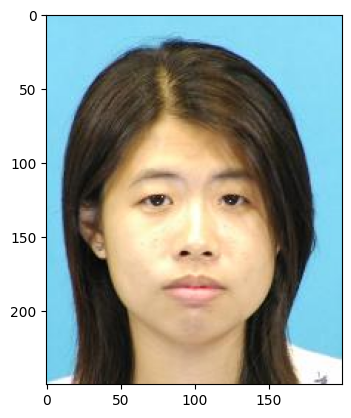

In [39]:
def exibir_imagens(lista_nomes):
  for img_name in lista_nomes:
    print(img_name)
    img_path = f"photos/{img_name}"
    img = image.load_img(img_path)
    plt.imshow(img)

img_path = f"photos/f-010-01.jpg"
img = image.load_img(img_path)
plt.imshow(img)
cv2.imread("photos/f-010-01.jpg").shape


### Preparação das imagens

In [40]:
img_array = []
genero = []
ALTURA = 250
LARGURA = 200

target_size = (200, 250)  # (largura, altura)

for img_name in tqdm(files_in_photos):
    genero_label = 1 if img_name.startswith('f') else 0  # 0 - masculino, 1 - feminino
    img_path = f"photos/{img_name}"
    img = cv2.imread(img_path, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Aumentação de dados
    transformadas = [img]  # Adicionar a original
    transformadas.append(cv2.flip(img, 1))  # Flip horizontal
    transformadas.append(cv2.flip(img, 0))  # Flip vertical
    transformadas.append(cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE))  # Rotação 90° horário
    transformadas.append(cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE))  # Rotação 90° anti-horário

    for img_aug in transformadas:
        img_aug = cv2.resize(img_aug, target_size)
        img_array.append(img_to_array(img_aug))
        genero.append(genero_label)

try:
    images = np.array(img_array)
    genero = np.array(genero)
    print("Formato das imagens:", images.shape)
except Exception as e:
    print("Erro ao converter para numpy array:", e)

print("Total de imagens e rótulos:", images.shape[0], len(genero))
# Verificando as formas
# for i, img in enumerate(img_array):
#     print(f"Imagem {i} - Forma: {img.shape}")


100%|██████████| 188/188 [00:02<00:00, 82.91it/s]


Formato das imagens: (940, 250, 200, 3)
Total de imagens e rótulos: 940 940


## Dividindo o Dataset


* 50% para o conjunto de treinamento,
* 30% para o conjunto de validação
* 20% para o conjunto de teste: reservado para avaliar o desempenho final do modelo.Item de lista


Quantidade de imagens de treino: 470
Quantidade de imagens de validação: 282
Quantidade de imagens de test: 188

Distribuição no conjunto de treino: Masculino - 335, Feminino - 135
Distribuição no conjunto de validação: Masculino - 201, Feminino - 54
Distribuição no conjunto de teste: Masculino - 134, Feminino- 54


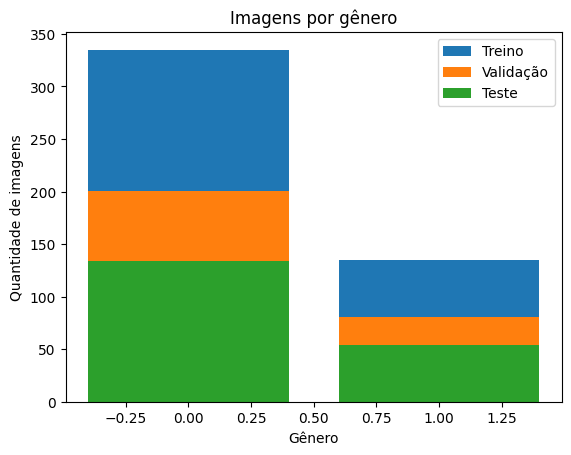

In [41]:
# Dividindo o dataset de treino em treino e validação de forma balanceada
from sklearn.model_selection import train_test_split
x_train, x_temp, y_train, y_temp  = train_test_split(images, genero, test_size=0.5, random_state=23, stratify=genero)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.4, random_state=23, stratify=y_train)


# Checando quantidade de imagens do dataset
print('Quantidade de imagens de treino:', x_train.shape[0])
print('Quantidade de imagens de validação:', x_val.shape[0])
print('Quantidade de imagens de test:', x_test.shape[0])

# print(type(x_train), x_train.shape)
# print(type(y_train), y_train.shape)
# print(type(x_val), x_val.shape)
# print(type(y_val), y_val.shape)

# Contando quantidade de imagens por categoria (masculino/feminino)
generos = ['Masculino', 'Feminino']

counterTrain=collections.Counter(y_train)
counterVal=collections.Counter(y_val)
counterTest=collections.Counter(y_test)

print(f"\nDistribuição no conjunto de treino: Masculino - {dict(counterTrain)[0]}, Feminino - {dict(counterTrain)[1]}")
print(f"Distribuição no conjunto de validação: Masculino - {dict(counterVal)[0]}, Feminino - {dict(counterTest)[1]}")
print(f"Distribuição no conjunto de teste: Masculino - {dict(counterTest)[0]}, Feminino- {dict(counterTest)[1]}")

# Plotando quantidade de imagens de cada genero
fig, ax = plt.subplots()
rects1 = ax.bar(counterTrain.keys(), counterTrain.values(), label='Treino')
rects2 = ax.bar(counterVal.keys(), counterVal.values(), label='Validação')
rects3 = ax.bar(counterTest.keys(), counterTest.values(), label='Teste')

ax.set_title('Imagens por gênero')
ax.set_ylabel('Quantidade de imagens')
ax.set_xlabel('Gênero')
ax.legend()
plt.show()

In [42]:
# Formatando o dataset para funcionar como entrada do Keras

x_train = x_train.reshape(x_train.shape[0], 250, 200, 3)
x_val = x_val.reshape(x_val.shape[0], 250, 200, 3)
x_test = x_test.reshape(x_test.shape[0], 250, 200, 3)

# Convertento valores dos pixels para float (garantindo precisão em operações de divisão por exemplo)
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')

# Normalizando os valores dos pixels (valores entre 0 e 1).
x_train /= 255
x_val /= 255
x_test /= 255

## Arquitetura da CNN

In [43]:
# Inicializando a CNN

model = Sequential()
input_shape = (250, 200, 3)

# Comvolução com filtro 3x3
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(256,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(512,(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())
# Camada densa
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

# Output
model.add(Dense(1, activation='sigmoid'))

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 248, 198, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 124, 99, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 124, 99, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 122, 97, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 61, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 61, 48, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 59, 46, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 29, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 29, 23, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 27, 21, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 13, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 13, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 11, 8, 512)          │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 5, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 5, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 10240)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       5,243,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,812,481 (25.99 MB)

 Trainable params: 6,812,481 (25.99 MB)

 Non-trainable params: 0 (0.00 B)

## Treinando a CNN

In [44]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

#model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss', patience= 3, restore_best_weights=True, verbose=0)

# Efetuando o treinamento de 10 épocas com o dataset de treino e validando no dataset de validação
history = model.fit(x_train, y_train, validation_data=(x_val,y_val), epochs=30, batch_size=16, shuffle=False, callbacks=[early_stoping,learning_rate_reduction])





Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.6394 - loss: 1.0344 - val_accuracy: 0.7128 - val_loss: 0.6393 - learning_rate: 0.0010
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 137s 3s/step - accuracy: 0.7161 - loss: 0.6182 - val_accuracy: 0.7128 - val_loss: 0.6116 - learning_rate: 0.0010
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7162 - loss: 0.6042
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
30/30 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.7161 - loss: 0.6043 - val_accuracy: 0.7128 - val_loss: 0.6131 - learning_rate: 0.0010
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.7161 - loss: 0.5898 - val_accuracy: 0.7128 - val_loss: 0.5819 - learning_rate: 5.0000e-04
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7162 - loss: 0.5575
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
30/30 ━━━━━━━━━━━━━━━━━━━━ 140s 3s/step - accuracy: 0.7161 - loss: 0.5576 - val_accur

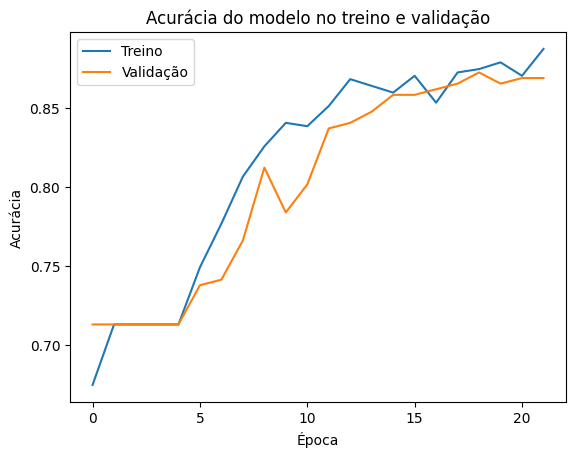

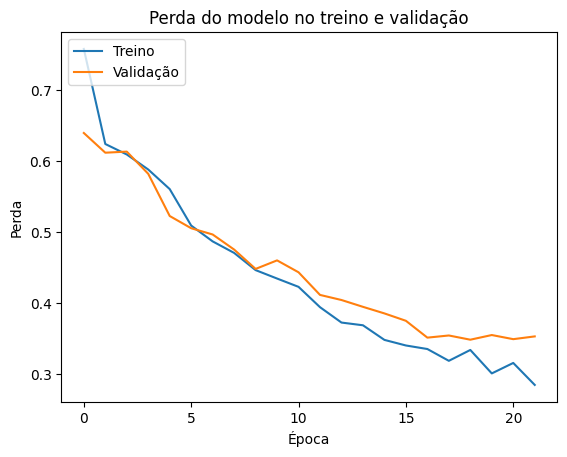

In [45]:
# Plotando o histórico de treino
train_loss = history.history['loss']
test_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
test_accuracy = history.history['val_accuracy']

# Histórico de acurácia
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Acurácia do modelo no treino e validação')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()

# # Histórico da função de perda
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perda do modelo no treino e validação')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['Treino', 'Validação'], loc='upper left')
plt.show()

## Avaliando a CNN treinada

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8940 - loss: 0.3218

Perda:0.388
Acurácia:0.8563829660415649
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step

O gênero predito da imagem é: Masculino


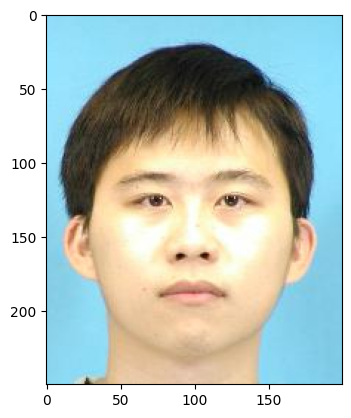

In [46]:

score = model.evaluate(x_test, y_test)

print( '\nPerda:{:.3f}\nAcurácia:{}'.format(score[0], score[1] ) )

# Imprimindo uma imagem de exemplo
image_index = 59
plt.imshow(x_test[image_index])

# Predizendo o genero dessa imagem
pred = model.predict(x_test[image_index].reshape(1, 250, 200, 3) )
genero_previsto = pred.argmax()
if genero_previsto:
  print( '\nO gênero predito da imagem é: Feminino')
else:
  print( '\nO gênero predito da imagem é: Masculino')

In [48]:
y_pred_raw = model.predict(x_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step


Desempenho

6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step
F1-Score: 0.6824
AUC-ROC: 0.8664


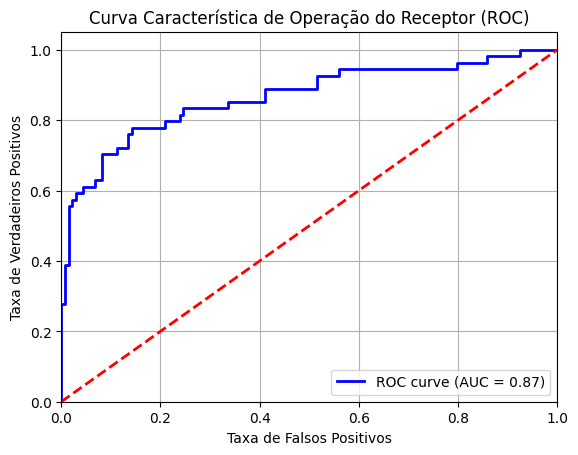

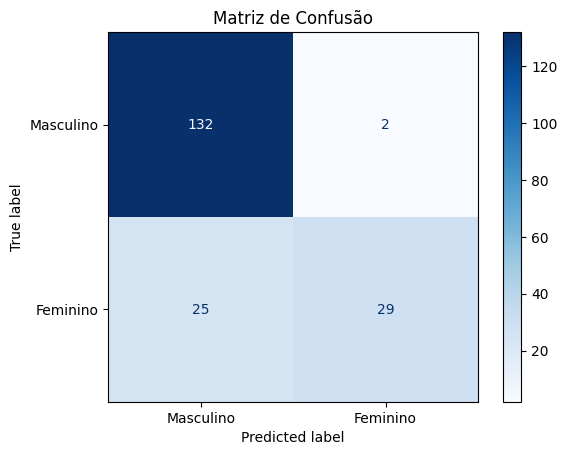

In [57]:
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay

# Geração das previsões
y_pred_raw = model.predict(x_test)  # Gera as probabilidades de cada classe

# Se for um problema binário, convertemos as probabilidades em rótulos binários
threshold = 0.5
y_pred = (y_pred_raw >= threshold).astype(int)  # Rótulos preditivos (0 ou 1)

# test_labels deve ser um array de inteiros onde cada valor é 0 (classe negativa) ou 1 (classe positiva)
y_true = y_test  # Rótulos verdadeiros que você possui

# Cálculo do F1-Score
f1 = f1_score(y_true, y_pred)  # Calcula o F1-Score
print(f"F1-Score: {f1:.4f}")

fpr, tpr, thresholds = roc_curve(y_true, y_pred_raw)  # Use as probabilidades para a curva ROC
roc_auc = auc(fpr, tpr)  # Calcula a AUC-ROC
print(f"AUC-ROC: {roc_auc:.4f}")  # Exibe o valor da AUC-ROC

# Plotando a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')  # Linha de chance
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva Característica de Operação do Receptor (ROC)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Cálculo e exibição da matriz de confusão
cm = confusion_matrix(y_true, y_pred)  # Computa a matriz de confusão
cmd = ConfusionMatrixDisplay(cm, display_labels=['Masculino', 'Feminino'])  # Rótulos para as classes
cmd.plot(cmap=plt.cm.Blues)  # Plota a matriz de confusão
plt.title('Matriz de Confusão')
plt.show()

